# Exercise - Knowledge Base Agent - STARTER

In this exercise, you’ll build a Knowledge Base Agent using LangGraph, which can:

Efficiently process long documents using text embedding and chunking.
Retrieve information from a vector database.
Augment user queries with retrieved contextual documents.
Generate accurate responses using an LLM.


**Challenge**

Your task is to create a LangGraph Workflow that includes:

- A document loading and vectorization process for a knowledge base.
- An Agent Node capable of:
    - Retrieving relevant knowledge.
    - Augmenting responses with contextual documents.
    - Generating accurate answers.
- Conditional routing to control query resolution.
- Optimization techniques such as text chunking and embedding search.

By the end of this exercise, you’ll have built an AI-powered Knowledge Base Agent that uses a structured process to generate accurate answers.



## 0. Import the necessary libs

In [16]:
from typing import List
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_community.document_loaders import PyPDFLoader
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import MessagesState
from IPython.display import Image, display
from rich.pretty import Pretty

import os
import dotenv

dotenv.load_dotenv()

True

## 1. Instantiate Chat Model with your API Key

To be able to connect with OpenAI, you need to instantiate an ChatOpenAI client passing your OpenAI key.

You can pass the `api_key` argument directly.
```python
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    api_key="voc-",
)
```

In [3]:
# Instantiate your chat model
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    api_key = os.getenv("OPEN_AI_API_KEY"),
)

In [5]:
# Instantiate your embeddings model
embeddings_fn = OpenAIEmbeddings(
    model="text-embedding-3-large",
    api_key = os.getenv("OPEN_AI_API_KEY")
)

## 2. Load and Process Documents

In [6]:
# Create your Chroma vector store with a collection name 
# and the embedding function
vector_store = Chroma(
    collection_name="udacity",
    embedding_function=embeddings_fn
)

In [7]:
file_path = "compact-guide-to-large-language-models.pdf"

In [8]:
loader = PyPDFLoader(file_path)

In [9]:
pages = []
async for page in loader.alazy_load():
    pages.append(page)

In [10]:
# Create a text splitter with chunk_size and chunk_overlap 
# values of 1000 and 200, respectively
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

In [11]:
all_splits = text_splitter.split_documents(pages)

In [25]:
_ = vector_store.add_documents(documents=all_splits)

## 3. Define State Schema

We define a State Schema for managing:

- User query
- Retrieved documents
- Generated answer

In [48]:
# Create your state schema named State inheriting from MessagesState
# with question(str), documents(List) and answer(str) attributes

class State(MessagesState):
    question: str
    documents: List[str]
    answer: str

## 4. RAG Nodes

The agent should:
- fetch relevant document chunks based on the user query
- combine the retrieved documents and use them as context
- invoke the LLM to generate a response

In [49]:
def retrieve(state: State):
    question = state["question"]

    # Use the vector store to retrieve similar documents to the question
    # Use the similarity_search() method
    retrieved_docs = vector_store.similarity_search(question)

    return {"documents": retrieved_docs}

In [50]:
def augment(state: State):
    question = state["question"]
    documents = state["documents"]
    docs_content = "\n\n".join(doc.page_content for doc in documents)

    # Create a RAG ChatPromptTemplate with question and context variables
    template = ChatPromptTemplate([
        ("system", "You are an assistant for question-answering tasks."),
        ("human", "Use the following pieces of retrieved context to answer the question. "
                "If you don't know the answer, just say that you don't know. " 
                "Use three sentences maximum and keep the answer concise. "
                "\n# Question: \n-> {question} "
                "\n# Context: \n-> {context} "
                "\n# Answer: "),
    ])

    messages = template.invoke(
        {"context": docs_content, "question": question}
    ).to_messages()

    return {"messages": messages}

In [51]:
def generate(state: State):
    # Invoke the LLM passing the messages from state
    ai_message = llm.invoke(state["messages"])
    return {"answer": ai_message.content, "messages": ai_message}

## 5. Build the LangGraph Workflow

In [52]:
workflow = StateGraph(State)
# Add all the nodes and edges
workflow.add_node("retrieve", retrieve)
workflow.add_node("augment", augment)
workflow.add_node("generate", generate)

workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "augment")
workflow.add_edge("augment", "generate")
workflow.add_edge("generate", END)

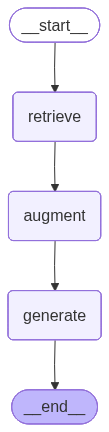

In [53]:
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

## 6. Invoke the Agent with a Query

Run and Print the retrieved documents to check search accuracy.

In [54]:
output = graph.invoke(
    {"question": "What are Open source models?"}
)

In [56]:
output["answer"]

'Open source models are language models developed and shared by the community, allowing users to access and utilize them for various tasks like text generation and classification. They offer advantages such as cost control, data privacy, and the ability to fine-tune the models to specific datasets. While they are rapidly improving, they have not yet fully matched the performance of leading proprietary models like GPT-4.'

In [58]:
for message in output["messages"]:
    message.pretty_print()

================================ System Message ================================

You are an assistant for question-answering tasks.
================================ Human Message =================================

Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise. 
# Question: 
-> What are Open source models? 
# Context: 
-> very limited use, so cost becomes a factor in applying these at scale.
In summary: Proprietary services are great to use if you have very complex tasks, 
are okay with sharing your data with a third party, and are prepared to incur 
costs if operating at any significant scale.  
Open source models
The other avenue for language models is to go to the open source community, 
where there has been similarly explosive growth over the past few years. 
Communities like Hugging Face  gather hundreds of thousands of models 
from contributo

## 7. Experiment

Now that you understood how it works, experiment with new things.

- Change the embedding model
- Change the parameters of RecursiveCharacterTextSplitter(chunk_size and chunk_overlap)
- Use your own document
- Add More File Types